In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix

# Computing the electron-defect interaction matrix elements
Suppose we have a pristine system with a Hamiltonian $H_p$ which we can diagonalize or write in the Wannier basis
\begin{equation}
    H_p = VDV^\textdagger = WAW^\textdagger.
\end{equation}
Now, we are interested in a system with some defect (vacancy or dopping). With this perturbation, our Hamiltonian is now
\begin{equation}
    H' = H_p + H_d.
\end{equation}
What we wish to compute are the matrix elements $W^\textdagger H_d W$. Let's see how can do this. 

First, suppose that we can diagonalize the new Hamiltonian $H' = V'D'V'^\textdagger$. Then, we have
\begin{align}
    W^\textdagger H' W &= W^\textdagger H_p W + W^\textdagger H_d W, \\
    W^\textdagger V'D'V'^\textdagger W &= W^\textdagger W A W^\textdagger W + W^\textdagger H_d W,\\
\end{align}
which we can rearrange to get (using the orthonormality of the Wannier functions)
\begin{equation}
\boxed{
    W^\textdagger H_d W =  W^\textdagger V'D'V'^\textdagger W - A}
\end{equation}

The maximally localized Wannier functions (MLWFs) are related to the eigenstates of the system by a unitary transformation 
\begin{equation}
    W = VU \implies U = V^{-1}W
\end{equation}
Plugging this above we get an expression for the $A$ matrix
\begin{equation}
    A = U^\textdagger D U
\end{equation}

#### Nearest neighbours only

In [12]:
# parameters
Nx = 2  # number of unit cells in each direction
N = 2 * Nx * Nx  # total number of atoms
t = 2.7  # hopping parameter in eV (typical value for graphene)

def site_index(i, j, s, Nx):
    """"
    Function that computes the site index of an atom in the supercell. 
    Inputs:
        i: scalar: unit cell index in the x direction
        j: scalar: unit cell index in the y direction
        s: [0,1]: type of atom in the unit cell (A: s=0, B: s=1)
        Nx: scalar: number of unit cells in each direction 
    """
    return (j * Nx + i) * 2 + s

# initializing the hamiltonian matrix for the pristine supercell
H_p = np.zeros((N, N))

# fill the hamiltonian, nearest neighbours only
for i in range(Nx):
    for j in range(Nx):
        # A site index
        iA = site_index(i, j, 0, Nx)
        
        # nearest B neighbors with PBC
        # neighbor 1: B in same unit cell (i, j)
        iB1 = site_index(i, j, 1, Nx)
        
        # neighbor 2: B in unit cell at (i-1, j) 
        iB2 = site_index((i-1)%Nx, j, 1, Nx)
        
        # neighbor 3: B in unit cell at (i-1, j+1)
        iB3 = site_index((i - 1) % Nx, (j + 1) % Nx, 1, Nx)
        
        # filling the matrix
        for iB in [iB1, iB2, iB3]:
            H_p[iA, iB] = -t
            H_p[iB, iA] = -t  # enforces hermicity

# verifying that the pristine hamiltonian is indeed Hermitian
assert np.allclose(H_p, H_p.conj().T), "Hamiltonian is not Hermitian"

# diagonalizing pristine supercell
eigvals_p, V = np.linalg.eigh(H_p)
D = np.diag(eigvals_p)

# computing the positions of the atoms in the supercell
a = 1 # lattice constant

# lattice vectors
a1 = (a/2)*np.array([3, np.sqrt(3)])
a2 = (a/2)*np.array([3, -np.sqrt(3)])

# positions of atoms in a unit cell
tau1 = np.array([0,0])
tau2 = a*np.array([1,0])

positions = []

for m in range(Nx):
    for n in range(Nx):
        R = m*a1 + n*a2
        positions.append(R + tau1)
        positions.append(R + tau2)
        
positions = np.array(positions) # 50x2 array with ith row giving (x,y) of ith atom in the supercell

print(H_p)

[[ 0.  -2.7  0.  -2.7  0.   0.   0.  -2.7]
 [-2.7  0.  -2.7  0.   0.   0.  -2.7  0. ]
 [ 0.  -2.7  0.  -2.7  0.  -2.7  0.   0. ]
 [-2.7  0.  -2.7  0.  -2.7  0.   0.   0. ]
 [ 0.   0.   0.  -2.7  0.  -2.7  0.  -2.7]
 [ 0.   0.  -2.7  0.  -2.7  0.  -2.7  0. ]
 [ 0.  -2.7  0.   0.   0.  -2.7  0.  -2.7]
 [-2.7  0.   0.   0.  -2.7  0.  -2.7  0. ]]


In [14]:
# simulating a defect
# removing atom A in the i=2, j=2 unit cell
i = 3
j = 3
s = 0
id = site_index(i, j, s, Nx)
print(id)
# constructing the TB hamiltonian matrix for the defect system
H_d = H_p.copy()
H_d[4,:] = 0
H_d[:, 4] = 0

# diagonalizing defect supercell
eigvals_d, V_ = np.linalg.eigh(H_d)
D_ = np.diag(eigvals_d)
print(H_d)

18
[[ 0.  -2.7  0.  -2.7  0.   0.   0.  -2.7]
 [-2.7  0.  -2.7  0.   0.   0.  -2.7  0. ]
 [ 0.  -2.7  0.  -2.7  0.  -2.7  0.   0. ]
 [-2.7  0.  -2.7  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -2.7  0.   0.   0.  -2.7  0. ]
 [ 0.  -2.7  0.   0.   0.  -2.7  0.  -2.7]
 [-2.7  0.   0.   0.   0.   0.  -2.7  0. ]]


#### Using MLWFs to compute the electron-defect matrix

In [5]:
# defining maximally localized Wannier functions
W = np.eye(N) # p_z orbital on each site

# unitary transformation between W and U, W = V@U
U = V.conj().T

# sanity check
A = U.conj().T @ D @ U
H_p_test = A

assert np.allclose(H_p, H_p_test)

In [6]:
# computing matrix elements
# W @ \Delta H @ W^\dag = W^\dag @ V' @ D' @ V'^\dag @ W - D

M = W.conj().T @ V_ @ D_ @ V_.conj().T @ W - A

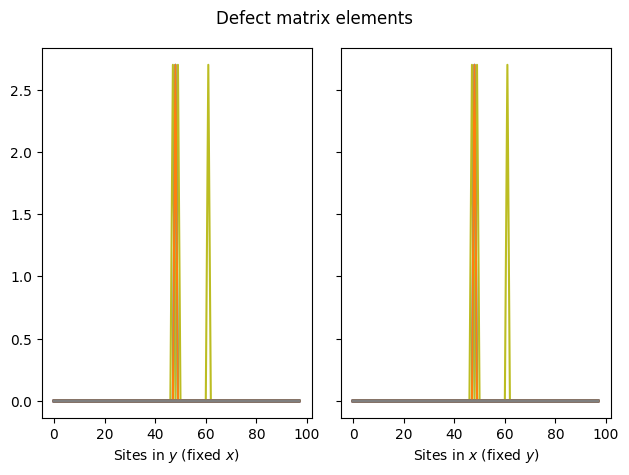

In [7]:
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Defect matrix elements')
for i in range(N):
    ax1.plot(M[i, :])
    ax1.set_xlabel("Sites in $y$ (fixed $x$)")
    ax2.plot(M[:, i])
    ax2.set_xlabel("Sites in $x$ (fixed $y$)")
plt.tight_layout()
plt.show()


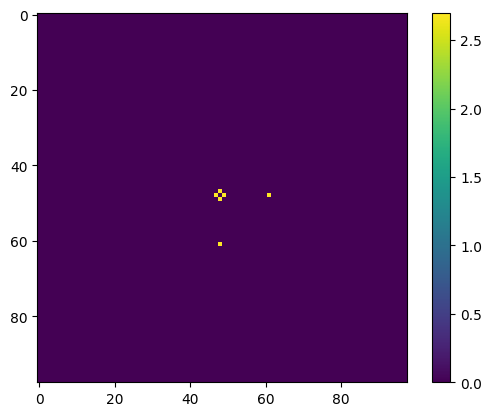

(array([47, 48, 48, 48, 49, 61]), array([48, 47, 49, 61, 48, 48]))


In [435]:
plt.imshow(M.T)
plt.colorbar()
plt.show()

print(np.where(np.round(M) != 0))

#### Green's function and transfer matrix
The key quantity is interacting Green's function of the perturbed system
\begin{equation}
    G(\omega) = G_0(\omega) + G_0(\omega)T(\omega)G_0(\omega)
\end{equation}
where
\begin{equation}
    G_0(\omega) =  (\omega + i\eta - H_p)^{-1},
\end{equation}
is the pristine Green's function and
\begin{equation}
    T(\omega) = M(1-G_0(\omega)M)^{-1}
\end{equation}
is the $T$-matrix.\\

From the interacting Green's function we can get a few interesting physical quantities. The full density of states (DOS)
\begin{equation}
    D(\omega) = -\frac{1}{\pi}\text{Im}[\text{Tr}\,G(\omega)],
\end{equation}
the spectral function
\begin{equation}
    A(k,\omega) = -\frac{1}{\pi}\text{Im}\,G(k,\omega),
\end{equation}
where $G(k,\omega)$ is the Fourier transform of the Green's function
\begin{equation}
G(k, \omega) = \sum_{ij}e^{-ikr_i}G_{ij}(\omega)e^{ikr_j}.
\end{equation}

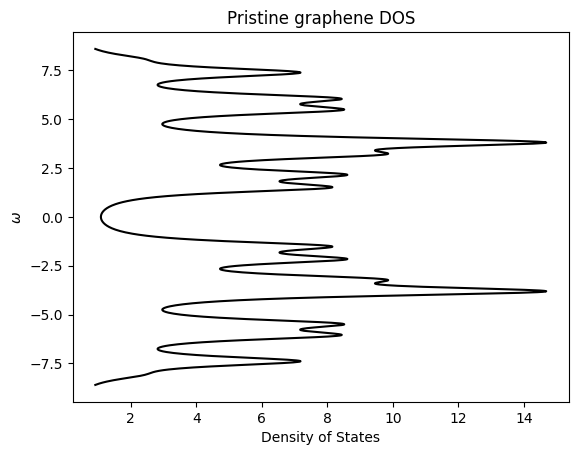

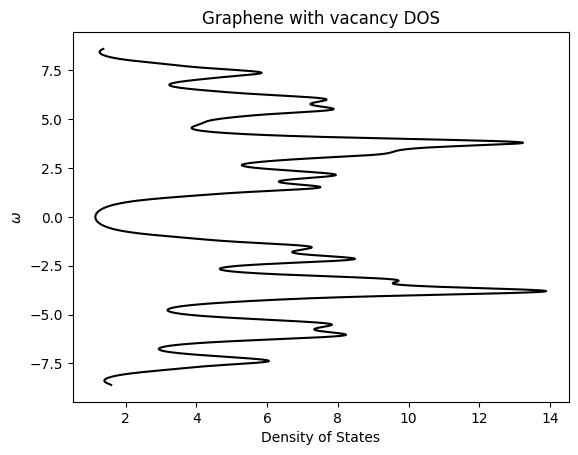

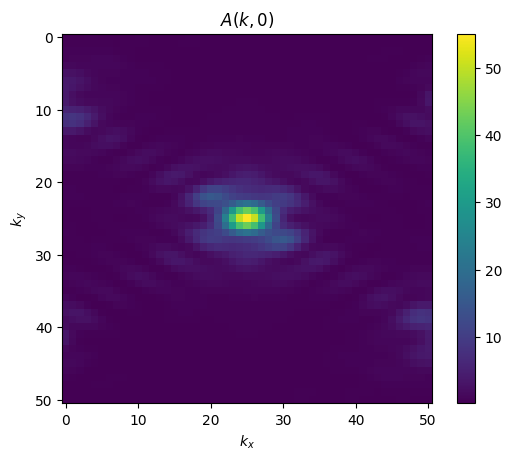

In [440]:
eta = 0.3
omega = np.linspace(D.min() - 0.5, D.max() + 0.5, 1001)
L = len(omega)
G0 = np.zeros((N,N, L), dtype=complex)
T = np.zeros((N,N, L), dtype=complex)
G = np.zeros((N,N,L), dtype=complex)
I = np.eye(N)

# constructing the pristine Green's function
for i, w in enumerate(omega):
    G0[:,:, i] = np.linalg.inv((w + eta*1j)*I - H_p)

#  constructing the T-matrix and interacting Green's function
for i, w in enumerate(omega):
    T[:,:,i] = M @ np.linalg.inv(I - G0[:,:, i] @ M)
    G[:,:,i] = G0[:,:, i] + G0[:,:,i] @ T[:,:,i] @ G0[:,:,i]
    
# sanity check, pristine graphene DOS
dos = -np.imag(np.trace(G0, axis1=0, axis2=1)) / np.pi
plt.plot(dos, omega, 'k-')
plt.title("Pristine graphene DOS")
plt.xlabel("Density of States")
plt.ylabel("$\\omega$")
plt.show()

# defect graphene DOS
dos = -np.imag(np.trace(G, axis1=0, axis2=1)) / np.pi
plt.plot(dos, omega, 'k-')
plt.title("Graphene with vacancy DOS")
plt.xlabel("Density of States")
plt.ylabel("$\\omega$")
plt.show()

# computing the spectral function
Nk = 51
ks = np.linspace(-np.pi/a, np.pi/a, Nk)
# k-space interacting Green's function
Gk = np.zeros((Nk,Nk, L), dtype=complex)
for ix, kx in enumerate(ks):
    for iy, ky in enumerate(ks):
        phase = np.exp(-1j * (kx * positions[:,0] + ky * positions[:,1]))
        phase_dag = phase.conj()
        
        for l in range(L):
            Gk[ix, iy, l] = phase_dag @ ( G[:, : , l] @ phase)
# spectral function
Ak = -np.imag(Gk) / np.pi

plt.imshow(Ak[:,:,0])
plt.colorbar()
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("$A(k,0)$")
plt.show()

#### Using the delocalized energy eigenstates to construct the electron-defect matrix


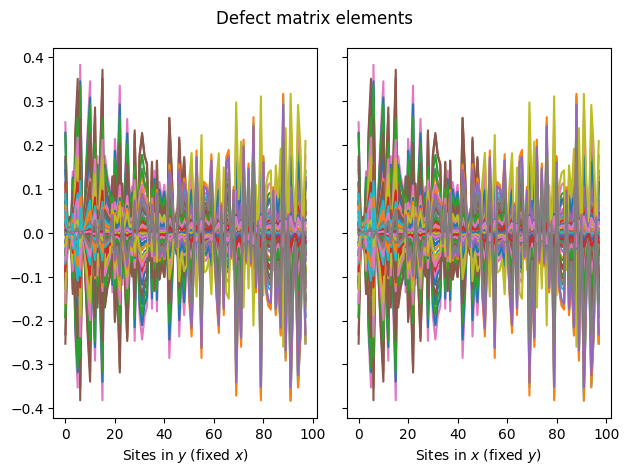

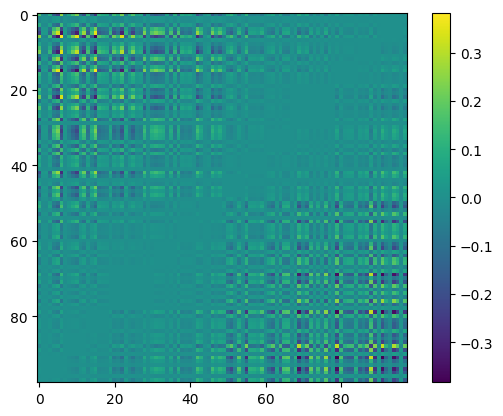

In [439]:
M = V.conj().T @ V_ @ D_ @ V_.conj().T @ V - D
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Defect matrix elements')
for i in range(N):
    ax1.plot(M[i, :])
    ax1.set_xlabel("Sites in $y$ (fixed $x$)")
    ax2.plot(M[:, i])
    ax2.set_xlabel("Sites in $x$ (fixed $y$)")
plt.tight_layout()
plt.show()

plt.imshow(M.T)
plt.colorbar()
plt.show()

#### 2 nearest neighbours!

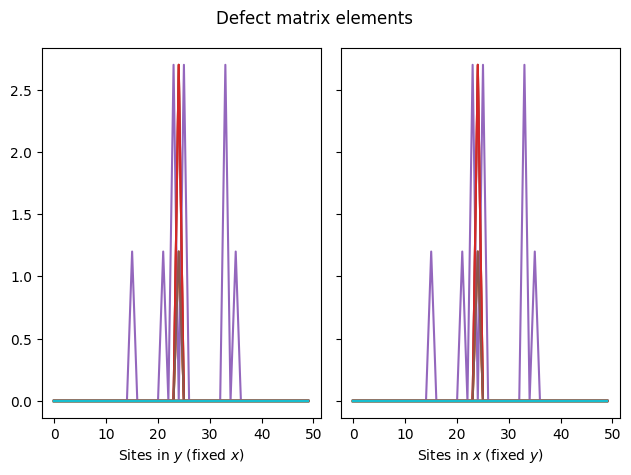

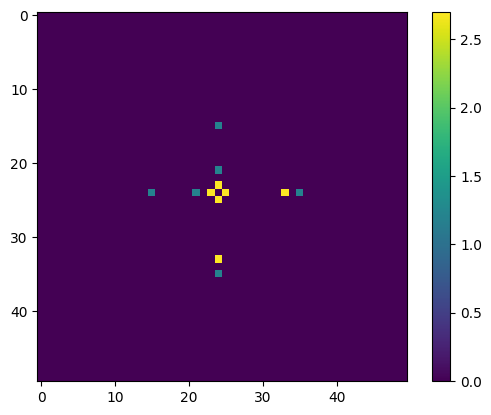

In [352]:
# parameters
Nx = 5  # number of unit cells in each direction
N = 2 * Nx * Nx  # total number of atoms
t1 = 2.7; t2 = 1.2  # hopping parameters in eV 

# initializing the hamiltonian matrix for the pristine supercell
H_p = np.zeros((N, N))

# fill the hamiltonian, 2 nearest neighbours only
for i in range(Nx):
    for j in range(Nx):
        # A site index
        iA = site_index(i, j, 0, Nx)
        
        # nearest B neighbors with PBC
        # neighbor 1: B in same unit cell (i, j)
        i1B1 = site_index(i, j, 1, Nx)
        # neighbor 2: B in unit cell at (i-1, j) 
        i1B2 = site_index((i-1)%Nx, j, 1, Nx)
        # neighbor 3: B in unit cell at (i-1, j+1)
        i1B3 = site_index((i-1) % Nx, (j+1) % Nx, 1, Nx)
        
        # second nearest B neighbors with PBC
        # second nearest B neighbors with PBC
        # neighbor 1: B in the unit cell (i-2, j)
        i2B1 = site_index((i-2)%Nx, j, 1, Nx)
        # neighbor 2: B in unit cell at (i, j+1) 
        i2B2 = site_index(i, (j+1)%Nx, 1, Nx)
        # neighbor 3: B in unit cell at (i, j-1)
        i2B3 = site_index(i, (j-1)%Nx, 1, Nx)
        
        # filling the matrix
        for iB in [i1B1, i1B2, i1B3]:
            H_p[iA, iB] = -t1
            H_p[iB, iA] = -t1  # enforces hermicity
        for iB in  [i2B1, i2B2, i2B3]:
            H_p[iA, iB] = -t2
            H_p[iB, iA] = -t2
            
# verifying that the pristine hamiltonian is indeed Hermitian
assert np.allclose(H_p, H_p.conj().T), "Hamiltonian is not Hermitian"

# diagonalizing pristine supercell
eigvals_p, V = np.linalg.eigh(H_p)
D = np.diag(eigvals_p)

# simulating a defect
# removing atom A in the i=2, j=2 unit cell
i = 2
j = 2
id = site_index(i, j, 0, Nx)

# constructing the TB hamiltonian matrix for the defect system
H_d = H_p.copy()
H_d[id,:] = 0
H_d[:, id] = 0

# diagonalizing defect supercell
eigvals_d, V_ = np.linalg.eigh(H_d)
D_ = np.diag(eigvals_d)

# defining maximally localized Wannier functions
W = np.eye(N) # p_z orbital on each site

# unitary transformation between W and U, W = V@U
U = V.conj().T

# sanity check
A = U.conj().T @ D @ U
H_p_test = A

assert np.allclose(H_p, H_p_test)

# computing matrix elements
# W @ \Delta H @ W^\dag = W^\dag @ V' @ D' @ V'^\dag @ W - D

M = W.conj().T @ V_ @ D_ @ V_.conj().T @ W - A

# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Defect matrix elements')
for i in range(N):
    ax1.plot(M[i, :])
    ax1.set_xlabel("Sites in $y$ (fixed $x$)")
    ax2.plot(M[:, i])
    ax2.set_xlabel("Sites in $x$ (fixed $y$)")
plt.tight_layout()
plt.show()

plt.imshow(M.T)
plt.colorbar()
plt.show()